In [1]:
import numpy as np
import xarray as xr
import os
import pandas as pd
import glob

In [2]:
import sys ; sys.path.append("../..")
from ppe_tools import *

In [3]:
# set directories
exp_dir = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/'

### 1. Define Parameters and Ranges

In [6]:
csv='ctsm6lhc_paramranges_11262024.csv'
df = pd.read_csv(csv)
df_main = df[df['include'] == 1]
df_flagged = df[df['include'] == 0]
params=df_main['param'].values
flags = df_main['flag']

In [7]:
# grouped parameters
KCN=['kc_nonmyc','kn_nonmyc','akc_active','akn_active','ekc_active','ekn_active']
ACCLIM_SF=['vcmaxse_sf','jmaxse_sf','tpuse_sf']
TAU = ['bgc_tau_s1','bgc_tau_s2','bgc_tau_s3']
RF_LS = ['bgc_rf_l1s1','bgc_rf_l2s1','bgc_rf_l3s2']
RF_SS = ['bgc_rf_s2s1', 'bgc_rf_s2s3', 'bgc_rf_s3s1']
RF_CWD = ['rf_cwdl2', 'bgc_rf_cwdl3']

flagged_dict = {'KCN':KCN,'ACCLIM_SF':ACCLIM_SF,'TAU':TAU,'RF_LS':RF_LS,'RF_SS':RF_SS,'RF_CWD':RF_CWD}

### 2. Build Parameter Dictionary

In [8]:
def get_minmax(df,p):
    ix       = df['param']==p
    minval   = df['min'][ix].values[0]
    maxval   = df['max'][ix].values[0]
    pftmin   = df['pft_mins'][ix].values[0]
    pftmax   = df['pft_maxs'][ix].values[0]
    thisloc  = df['loc'][ix].values[0]

    needs_pft = (minval=='pft')
    if needs_pft:
        thismin = np.zeros((79))
        thismin[0:17] = np.fromstring(pftmin, dtype='float', sep=',')
    elif 'percent' in minval:
        thismin = minval
    else:
        thismin = np.array(float(minval))

    needs_pft = (maxval=='pft')
    if needs_pft:
        thismax = np.zeros((79))
        thismax[0:17] = np.fromstring(pftmax, dtype='float', sep=',')
    elif 'percent' in maxval:
        thismax = maxval
    else:
        thismax = np.array(float(maxval))

    return thismin, thismax, thisloc

In [9]:
lhcs = {}
for param,flag in zip(params,flags):
    
    if not pd.notnull(flag):
        thismin,thismax,thisloc = get_minmax(df,param)
        lhcs[param]={'min':thismin,'max':thismax,'loc':thisloc,'flagged':[]}
    else:
        flagged={}
        for p in flagged_dict[param]:
            thismin,thismax,thisloc = get_minmax(df_flagged,p)
            flagged[p]={'min':thismin,'max':thismax,'loc':thisloc}
        lhcs[param]={'min':[],'max':[],'loc':thisloc,'flagged':flagged}

### 4. Create the Ensemble Object

In [11]:
# 4a. instantiate the Ensemble object
basefile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/paramfiles/lhc0000.nc'
pdir = exp_dir + 'paramfiles/'
ndir = exp_dir + 'namelist_mods/'
x    = Ensemble(basefile,pdir,ndir)

# 4b. add the new ensemble members
prefix = 'lhc'   #make your own prefix
nextnum=1
n_samples=1500  # set the number of ensemble members 
x.add_lhcs(lhcs,prefix,nextnum,n_samples,lhc=None) # for new LHC sample set lhc=None

### 5. Write the param_files

In [12]:
paramset_file = exp_dir + 'ctsm6lhc_11262024.txt'
x.write(lhcfile=paramset_file)

In [13]:
%%bash -s "$paramset_file"
# Check that the file was created
paramset_file=$1 

stat $paramset_file

  File: /glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt
  Size: 1631122   	Blocks: 3200       IO Block: 8388608 regular file
Device: 41h/65d	Inode: 4641803609  Links: 1
Access: (0644/-rw-r--r--)  Uid: (35240/  linnia)   Gid: ( 1000/    ncar)
Access: 2024-11-27 07:31:33.752754000 -0700
Modify: 2024-11-27 07:31:33.901596806 -0700
Change: 2024-11-27 07:31:33.901596806 -0700
 Birth: -


### 6. Sanity Check

In [4]:
import matplotlib.pyplot as plt

In [5]:
in_dir = exp_dir + 'paramfiles/'
filelist= np.sort(glob.glob(os.path.join(in_dir, '*')))

In [7]:
filelist[40]

'/glade/work/linnia/CLM6-PPE/ctsm6_lhc/paramfiles/lhc0040.nc'

In [11]:
check = np.empty([7,3])
for j,f in enumerate([40,85,1166,1286,1323,236,1389]):
    par = xr.open_dataset(filelist[f])
    for i,p in enumerate(['bsw_sf','hksat_sf','watsat_sf']):
        val = par[p]
        check[j,i] = val

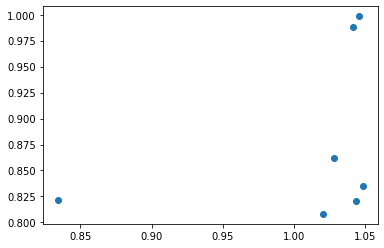

In [12]:
plt.scatter(check[:,0],check[:,2])

In [ ]:
### Check

In [13]:
crashers = [40,85,1166,1286,1323,236,1389]
files = [filelist[i] for i in crashers]
params = ['bsw_sf','hksat_sf','watsat_sf','sucsat_sf','om_frac_sf']

In [14]:
check = np.empty([100,5])
for j,f in enumerate(range(100)):
    par = xr.open_dataset(filelist[f])
    for i,p in enumerate(params):
        val = par[p]
        check[j,i] = val

In [20]:
crash = np.empty([7,5])
for j,f in enumerate([40,85,1166,1286,1323,236,1389]):
    par = xr.open_dataset(filelist[f])
    for i,p in enumerate(params):
        val = par[p]
        crash[j,i] = val

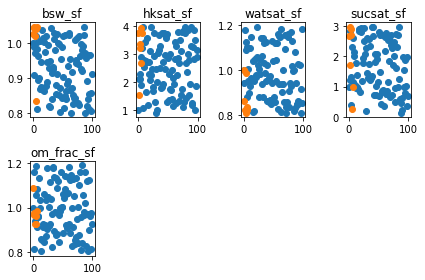

In [21]:
df_check = pd.DataFrame(check,columns=params)
df_crash = pd.DataFrame(crash,columns=params)
for i,p in enumerate(params):
    plt.subplot(2,4,i+1)
    plt.scatter(range(100),df_check[p])
    plt.scatter(range(7),df_crash[p])
    plt.title(p)
plt.tight_layout()

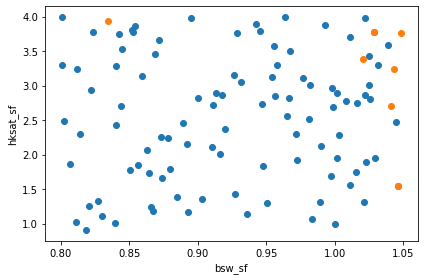

In [26]:

plt.scatter(df_check['bsw_sf'],df_check['hksat_sf'])
plt.scatter(df_crash['bsw_sf'],df_crash['hksat_sf'])
plt.xlabel('bsw_sf')
plt.ylabel('hksat_sf')
plt.tight_layout()